# Trajectory Optimization

Here we show a simple trajectory optimization example using the `TimeVaryingOpenLoopPolicy` and the `FirstOrderPolicyOptimizer`. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from score_po.policy_optimizer import (
    PolicyOptimizerParams,
    FirstOrderPolicyOptimizer)
from score_po.dynamical_system import DynamicalSystem
from score_po.costs import QuadraticCost
from score_po.policy import TimeVaryingOpenLoopPolicy

We'll define the parameters first, which includes the horizon, batch size, rate, etc. 
Note that we have `params.x0_upper = params.x0_lower`, since we are solving a trajectory optimization problem from a fixed initial point.

In [2]:
params = PolicyOptimizerParams()
params.T = 20
params.x0_upper = torch.Tensor([0.3, 0.2])
params.x0_lower = torch.Tensor([0.3, 0.2])
params.batch_size = 1
params.std = 1e-2
params.lr = 1e-6
params.max_iters = 100

Now we'll set up the dynamical system. We will choose the simple system of $f(x,u) = x + u$. To define this system, you'll need to make your own `DynamicalSystem` class and pass it onto `params`.

In [3]:
# 1. Set up dynamical system.
class SingleIntegrator(DynamicalSystem):
    def __init__(self):
        super().__init__(2, 2)
        self.is_differentiable = True

    def dynamics(self, x, u):
        return x + u

    def dynamics_batch(self, x_batch, u_batch):
        return x_batch + u_batch


dynamics = SingleIntegrator()
params.dynamical_system = dynamics


Then set up the cost function. Here we will use the quadartic cost 
$c_d(x_{T+1}) + \sum^{i=0}_{T} c(x_t, u_t)$ where 
$c_d(x) = (x-x_d)^\intercal \mathbf{Q}_d (x - x_d)$ and $c(x,u) = (x - x_d)^\intercal \mathbf{Q} (x - x_d) + u^\intercal \mathbf{R} u$.

In [4]:
# 2. Set up cost.
Q = torch.eye(2)
R = 1e-1 * torch.eye(2)
Qd = 100 * params.T * torch.eye(2)
xd = torch.zeros(2)
cost = QuadraticCost(Q, R, Qd, xd)
params.cost = cost

Finall choose a policy class. For trajectory optimization, the right policy class is the open loop command $\pi(x, t) = u_t$. We'll initialize this by using policy parameters, which is the zero policy.

In [5]:
# 3. Set up policy and initial guess.
policy = TimeVaryingOpenLoopPolicy(2, 2, params.T)
params.policy = policy
params.policy_params_0 = policy.get_parameters()


Now we can solve our problem, and visualize our trajectory. 

Iteration: 0000 | Cost: 262.600 | Time: 0.000
Iteration: 0001 | Cost: 233.606 | Time: 0.017
Iteration: 0002 | Cost: 195.710 | Time: 0.028
Iteration: 0003 | Cost: 162.889 | Time: 0.039
Iteration: 0004 | Cost: 146.374 | Time: 0.049
Iteration: 0005 | Cost: 129.315 | Time: 0.060
Iteration: 0006 | Cost: 108.757 | Time: 0.070
Iteration: 0007 | Cost: 89.993 | Time: 0.081
Iteration: 0008 | Cost: 78.265 | Time: 0.091
Iteration: 0009 | Cost: 64.859 | Time: 0.101
Iteration: 0010 | Cost: 50.178 | Time: 0.112
Iteration: 0011 | Cost: 41.040 | Time: 0.122
Iteration: 0012 | Cost: 35.397 | Time: 0.133
Iteration: 0013 | Cost: 27.264 | Time: 0.143
Iteration: 0014 | Cost: 24.254 | Time: 0.154
Iteration: 0015 | Cost: 20.111 | Time: 0.164
Iteration: 0016 | Cost: 18.153 | Time: 0.174
Iteration: 0017 | Cost: 16.002 | Time: 0.185
Iteration: 0018 | Cost: 15.947 | Time: 0.195
Iteration: 0019 | Cost: 14.279 | Time: 0.206
Iteration: 0020 | Cost: 12.097 | Time: 0.216
Iteration: 0021 | Cost: 11.784 | Time: 0.227
Ite

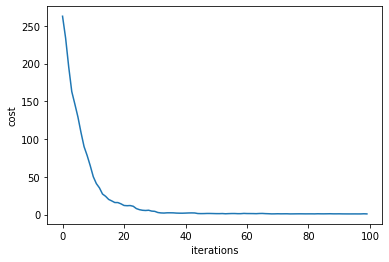

In [6]:
optimizer = FirstOrderPolicyOptimizer(params)
optimizer.iterate()
optimizer.plot_iterations()

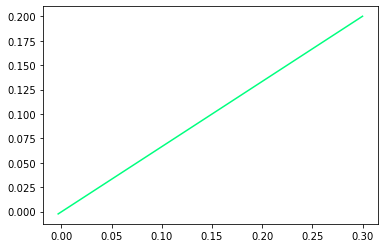

In [11]:
x0_batch = optimizer.sample_initial_state_batch()
zero_noise_trj = torch.zeros(params.batch_size, params.T, 2)
x_trj, u_trj = optimizer.rollout_policy_batch(x0_batch, zero_noise_trj)
x_trj = x_trj.detach().numpy()

plt.figure()
for b in range(params.batch_size):
    plt.plot(x_trj[b,:,0], x_trj[b,:,1], 'springgreen')
plt.show()
plt.close()